In [1]:
import os
import gc
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ezc3d import c3d
from scipy.signal import resample
from scipy.io import loadmat, savemat
from joblib import load, dump
from tqdm import tqdm
from scipy.signal import butter, lfilter, medfilt

# Constants

In [2]:
PATH_DATASETS = '../../Dataset/'
PATH_DATASET_1 = 'gait-dbase-1/'

N_SAMPLES = 1024
FORCE_THRESHOLD = 20
TOE_HEIGTH_THRESHOLD = 40

# Filter 

In [3]:
class LowPassFilter(object): 
    @staticmethod
    def butter_lowpass(cutoff, fs, order):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

    def apply(data, cutoff=6, fs=1500, order=2, axis=-1):
        b, a = LowPassFilter.butter_lowpass(cutoff, fs, order=order)
        y = lfilter(b, a, data, axis=axis)
        y = y - np.median(y)
        return y

# Functions

In [4]:
def standardize(x):
    # return (x - np.mean(x, axis=0)) / np.std(x, axis=0)
    return (x - np.min(x, axis=0)) / (np.max(x, axis=0) - np.min(x, axis=0))

def get_processed_grf(grf, clip=False):
    singn_corrected = grf # if np.mean(grf) > 20 else (-grf)
    processed_grf = LowPassFilter.apply(singn_corrected, fs=1500, cutoff=20)
    processed_grf = processed_grf - np.median(processed_grf)
    if clip:
        processed_grf[processed_grf < FORCE_THRESHOLD] = 0
    return resample(processed_grf, N_SAMPLES * 3, axis=0).T

def get_processed_moment(moment):
    processed_moment = LowPassFilter.apply(moment, fs=1500, cutoff=20)
    return resample(processed_moment, N_SAMPLES * 3, axis=0).T

def get_trajectories(content, foot='right'):
    if foot == 'right':
        trajectory_x = content['data']['points'][0, 9:15, :]
        trajectory_y = content['data']['points'][1, 9:15, :]
        trajectory_z = content['data']['points'][2, 9:15, :]

    elif foot == 'left':
        trajectory_x = content['data']['points'][0, 20:26, :]
        trajectory_y = content['data']['points'][1, 20:26, :]
        trajectory_z = content['data']['points'][2, 20:26, :]

    else:
        raise ValueError('Third foot is not allowed')

    # trajectory_x = LowPassFilter.apply(trajectory_x, fs=200, cutoff=20)
    # trajectory_y = LowPassFilter.apply(trajectory_y, fs=200, cutoff=20)
    # trajectory_z = LowPassFilter.apply(trajectory_z, fs=200, cutoff=20)

    trajectory_x = resample(trajectory_x, N_SAMPLES * 3, axis=1).T
    trajectory_y = resample(trajectory_y, N_SAMPLES * 3, axis=1).T
    trajectory_z = resample(trajectory_z, N_SAMPLES * 3, axis=1).T

    return trajectory_x, trajectory_y, trajectory_z

def get_force(content):
    force_x = []
    force_y = []
    force_z = []
    for i in range(2):
        force_x.append(
            get_processed_grf(
                content['data']['platform'][i]['force'][1, :]
            )
        )
        force_y.append(
            get_processed_grf(
                content['data']['platform'][i]['force'][0, :]
            )
        )
        force_z.append(
            get_processed_grf(
                content['data']['platform'][i]['force'][2, :], True
            )
        )

    return force_x, force_y, force_z

def get_moment(content):
    moment_x = []
    moment_y = []
    moment_z = []
    for i in range(2):
        moment_x.append(
            get_processed_moment(
                content['data']['platform'][i]['moment'][0, :]
            )
        )
        moment_y.append(
            get_processed_moment(
                content['data']['platform'][i]['moment'][1, :]
            )
        )
        moment_z.append(
            get_processed_moment(
                content['data']['platform'][i]['moment'][2, :]
            )
        )

    return moment_x, moment_y, moment_z

# Test Bench

In [5]:
path = '/home/ai/Python/GRF-Synthesis-from-Motion-Trajectories/Dataset/gait-dbase-1/2014001/2014001_C1_04.c3d'
content = c3d(path, extract_forceplat_data=True)

In [6]:
trajectory_x_r, trajectory_y_r, trajectory_z_r = get_trajectories(content, 'right')
trajectory_x_l, trajectory_y_l, trajectory_z_l = get_trajectories(content, 'left')

force_x, force_y, force_z = get_force(content)
moment_x, moment_y, moment_z = get_moment(content)

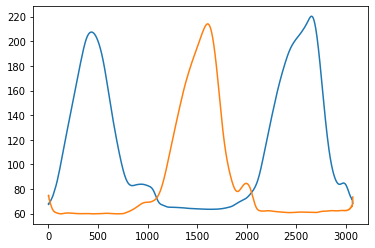

In [7]:
plt.plot(trajectory_z_l[:, 0])
plt.plot(trajectory_z_r[:, 0])
plt.show()

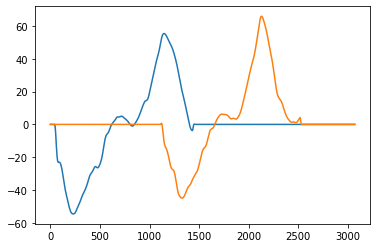

In [8]:
plt.plot(force_y[0])
plt.plot(force_y[1])
plt.show()

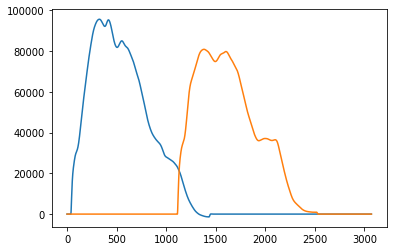

In [9]:
plt.plot(moment_y[0])
plt.plot(moment_y[1])
plt.show()

In [10]:
mask_force_z_1 = (force_z[0] > FORCE_THRESHOLD)
mask_force_z_2 = (force_z[1] > FORCE_THRESHOLD)

start_1 = np.min(np.argwhere(mask_force_z_1 == True))
end_1 = np.max(np.argwhere(mask_force_z_1 == True))

start_2 = np.min(np.argwhere(mask_force_z_2 == True))
end_2 = np.max(np.argwhere(mask_force_z_2 == True))

force_x_1 = force_x[0][start_1 : end_1]
force_y_1 = force_y[0][start_1 : end_1]
force_z_1 = force_z[0][start_1 : end_1]

force_x_2 = force_x[1][start_2 : end_2]
force_y_2 = force_y[1][start_2 : end_2]
force_z_2 = force_z[1][start_2 : end_2]

temp_l = trajectory_z_l[start_1 : end_1, 0]
temp_r = trajectory_z_r[start_1 : end_1, 0]

force_x_r = 0
force_y_r = 0
force_z_r = 0

force_x_l = 0
force_y_l = 0
force_z_l = 0

if np.sum(temp_l) > np.sum(temp_r):
    force_x_r = force_x_1
    force_y_r = force_y_1
    force_z_r = force_z_1

    force_x_l = force_x_2
    force_y_l = force_y_2
    force_z_l = force_z_2

    trajectory_x_r = trajectory_x_l[start_2 : end_2]
    trajectory_y_r = trajectory_y_r[start_2 : end_2]
    trajectory_z_r = trajectory_z_r[start_2 : end_2]

    trajectory_x_l = trajectory_x_r[start_1 : end_1]
    trajectory_y_l = trajectory_y_l[start_1 : end_1]
    trajectory_z_l = trajectory_z_l[start_1 : end_1]

else:
    force_x_l = force_x_1
    force_y_l = force_y_1
    force_z_l = force_z_1

    force_x_r = force_x_2
    force_y_r = force_y_2
    force_z_r = force_z_2

    trajectory_x_r = trajectory_x_l[start_1 : end_1]
    trajectory_y_r = trajectory_y_r[start_1 : end_1]
    trajectory_z_r = trajectory_z_r[start_1 : end_1]

    trajectory_x_l = trajectory_x_r[start_2 : end_2]
    trajectory_y_l = trajectory_y_l[start_2 : end_2]
    trajectory_z_l = trajectory_z_l[start_2 : end_2]

# ... Resample
trajectory_x_r = resample(trajectory_x_r, N_SAMPLES, axis=0)
trajectory_y_r = resample(trajectory_y_r, N_SAMPLES, axis=0)
trajectory_z_r = resample(trajectory_z_r, N_SAMPLES, axis=0)

trajectory_x_l = resample(trajectory_x_l, N_SAMPLES, axis=0)
trajectory_y_l = resample(trajectory_y_l, N_SAMPLES, axis=0)
trajectory_z_l = resample(trajectory_z_l, N_SAMPLES, axis=0)

force_x_r = resample(force_x_r, N_SAMPLES, axis=0)
force_y_r = resample(force_y_r, N_SAMPLES, axis=0)
force_z_r = resample(force_z_r, N_SAMPLES, axis=0)

force_x_l = resample(force_x_l, N_SAMPLES, axis=0)
force_y_l = resample(force_y_l, N_SAMPLES, axis=0)
force_z_l = resample(force_z_l, N_SAMPLES, axis=0)

# ... Standardize
trajectory_x_r = standardize(trajectory_x_r)
trajectory_y_r = standardize(trajectory_y_r)
trajectory_z_r = standardize(trajectory_z_r)

trajectory_x_l = standardize(trajectory_x_l)
trajectory_y_l = standardize(trajectory_y_l)
trajectory_z_l = standardize(trajectory_z_l)

force_x_r = standardize(force_x_r)
force_y_r = standardize(force_y_r)
force_z_r = standardize(force_z_r)

force_x_l = standardize(force_x_l)
force_y_l = standardize(force_y_l)
force_z_l = standardize(force_z_l)

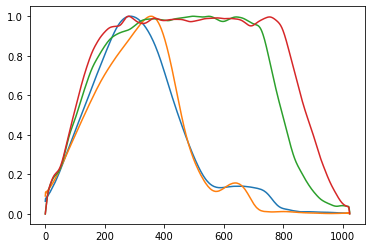

In [11]:
plt.plot(trajectory_z_l[:, 0])
plt.plot(trajectory_z_r[:, 0])
plt.plot(force_z_l)
plt.plot(force_z_r)

# Extract Features

In [5]:
path = os.path.join(PATH_DATASETS, PATH_DATASET_1)
subjects = os.listdir(path)

features = pd.DataFrame()
target = pd.DataFrame()

records = []
n_samples = 0
n_bad_samples = 0

subjects = subjects[:18]

for subject in tqdm(subjects):
    #     print(subject)
    files_path = os.path.join(path, subject)
    files = os.listdir(files_path)
    for filename in files:

        if "ST" in filename:
            continue

        # print(subject, filename, end=' ')

        try:
            content = c3d(
                os.path.join(path, subject, filename), extract_forceplat_data=True
            )

            # print('loaded', end=' ')

            trajectory_x_r, trajectory_y_r, trajectory_z_r = get_trajectories(
                content, "right"
            )
            trajectory_x_l, trajectory_y_l, trajectory_z_l = get_trajectories(
                content, "left"
            )

            force_x, force_y, force_z = get_force(content)
            moment_x, moment_y, moment_z = get_moment(content)

            del content
            gc.collect()

            force_combined_z = force_z[0] + force_z[1]
            force_mask = force_combined_z >= FORCE_THRESHOLD

            # ... Remove all zero GRF samples
            if (
                np.sum(force_z[0]) <= FORCE_THRESHOLD
                or np.sum(force_z[1]) <= FORCE_THRESHOLD
            ):
                # print(os.path.join(path, subject, filename))
                n_bad_samples = n_bad_samples + 1
                continue

            # ... Remove bad samples
            if np.mean(force_mask) <= 0.5:
                # print(os.path.join(path, subject, filename))
                n_bad_samples = n_bad_samples + 1
                continue

            # ... Remove samples that starts and ends abruptly
            if (
                np.mean(force_combined_z[:10]) >= 200
                or np.mean(force_combined_z[-10:]) >= 200
            ):
                # print(os.path.join(path, subject, filename))
                n_bad_samples = n_bad_samples + 1
                continue

            mask_force_z_1 = force_z[0] > FORCE_THRESHOLD
            mask_force_z_2 = force_z[1] > FORCE_THRESHOLD

            start_1 = np.min(np.argwhere(mask_force_z_1 == True))
            end_1 = np.max(np.argwhere(mask_force_z_1 == True))

            if (end_1 - start_1) < 700 or (end_1 - start_1) > 1700:
                n_bad_samples = n_bad_samples + 1
                continue

            start_2 = np.min(np.argwhere(mask_force_z_2 == True))
            end_2 = np.max(np.argwhere(mask_force_z_2 == True))

            if (end_2 - start_2) < 700 or (end_2 - start_2) > 1700:
                n_bad_samples = n_bad_samples + 1
                continue

            # print('1', end=' ')

            force_x_1 = force_x[0][start_1:end_1]
            force_y_1 = force_y[0][start_1:end_1]
            force_z_1 = force_z[0][start_1:end_1]

            force_x_2 = force_x[1][start_2:end_2]
            force_y_2 = force_y[1][start_2:end_2]
            force_z_2 = force_z[1][start_2:end_2]

            moment_x_1 = moment_x[0][start_1:end_1]
            moment_y_1 = moment_y[0][start_1:end_1]
            moment_z_1 = moment_z[0][start_1:end_1]

            moment_x_2 = moment_x[1][start_2:end_2]
            moment_y_2 = moment_y[1][start_2:end_2]
            moment_z_2 = moment_z[1][start_2:end_2]

            temp_l = trajectory_z_l[start_1:end_1, 0]
            temp_r = trajectory_z_r[start_1:end_1, 0]

            force_x_r = 0
            force_y_r = 0
            force_z_r = 0

            force_x_l = 0
            force_y_l = 0
            force_z_l = 0

            moment_x_r = 0
            moment_y_r = 0
            moment_z_r = 0

            moment_x_l = 0
            moment_y_l = 0
            moment_z_l = 0

            if np.sum(temp_l) > np.sum(temp_r):
                force_x_r = force_x_1
                force_y_r = force_y_1
                force_z_r = force_z_1

                force_x_l = force_x_2
                force_y_l = force_y_2
                force_z_l = force_z_2

                moment_x_r = moment_x_1
                moment_y_r = moment_y_1
                moment_z_r = moment_z_1

                moment_x_l = moment_x_2
                moment_y_l = moment_y_2
                moment_z_l = moment_z_2

                trajectory_x_r = trajectory_x_l[start_2:end_2]
                trajectory_y_r = trajectory_y_r[start_2:end_2]
                trajectory_z_r = trajectory_z_r[start_2:end_2]

                trajectory_x_l = trajectory_x_r[start_1:end_1]
                trajectory_y_l = trajectory_y_l[start_1:end_1]
                trajectory_z_l = trajectory_z_l[start_1:end_1]

            else:
                force_x_l = force_x_1
                force_y_l = force_y_1
                force_z_l = force_z_1

                force_x_r = force_x_2
                force_y_r = force_y_2
                force_z_r = force_z_2

                moment_x_l = moment_x_1
                moment_y_l = moment_y_1
                moment_z_l = moment_z_1

                moment_x_r = moment_x_2
                moment_y_r = moment_y_2
                moment_z_r = moment_z_2

                trajectory_x_r = trajectory_x_l[start_1:end_1]
                trajectory_y_r = trajectory_y_r[start_1:end_1]
                trajectory_z_r = trajectory_z_r[start_1:end_1]

                trajectory_x_l = trajectory_x_r[start_2:end_2]
                trajectory_y_l = trajectory_y_l[start_2:end_2]
                trajectory_z_l = trajectory_z_l[start_2:end_2]

            # print('2', end=' ')

            # ... Resample
            trajectory_x_r = resample(trajectory_x_r, N_SAMPLES, axis=0)
            trajectory_y_r = resample(trajectory_y_r, N_SAMPLES, axis=0)
            trajectory_z_r = resample(trajectory_z_r, N_SAMPLES, axis=0)

            trajectory_x_l = resample(trajectory_x_l, N_SAMPLES, axis=0)
            trajectory_y_l = resample(trajectory_y_l, N_SAMPLES, axis=0)
            trajectory_z_l = resample(trajectory_z_l, N_SAMPLES, axis=0)

            force_x_r = resample(force_x_r, N_SAMPLES, axis=0)
            force_y_r = resample(force_y_r, N_SAMPLES, axis=0)
            force_z_r = resample(force_z_r, N_SAMPLES, axis=0)

            force_x_l = resample(force_x_l, N_SAMPLES, axis=0)
            force_y_l = resample(force_y_l, N_SAMPLES, axis=0)
            force_z_l = resample(force_z_l, N_SAMPLES, axis=0)

            moment_x_r = resample(moment_x_r, N_SAMPLES, axis=0)
            moment_y_r = resample(moment_y_r, N_SAMPLES, axis=0)
            moment_z_r = resample(moment_z_r, N_SAMPLES, axis=0)

            moment_x_l = resample(moment_x_l, N_SAMPLES, axis=0)
            moment_y_l = resample(moment_y_l, N_SAMPLES, axis=0)
            moment_z_l = resample(moment_z_l, N_SAMPLES, axis=0)

            # print('3', end=' ')

            # ... sign correction
            if np.mean(force_y_r[: int(N_SAMPLES / 2)]) > 0:
                force_y_r = -force_y_r
            if np.mean(force_y_l[: int(N_SAMPLES / 2)]) > 0:
                force_y_l = -force_y_l

            if np.mean(force_x_r) < 0:
                force_x_r = -force_x_r
            if np.mean(force_x_l) < 0:
                force_x_l = -force_x_l

            if np.mean(moment_x_r) < 0:
                moment_x_r = -moment_x_r
            if np.mean(moment_x_l) < 0:
                moment_x_l = -moment_x_l

            if np.mean(moment_y_r[: int(N_SAMPLES / 2)]) > 0:
                moment_y_r = -moment_y_r
            if np.mean(moment_y_l[: int(N_SAMPLES / 2)]) > 0:
                moment_y_l = -moment_y_l

            if np.mean(moment_z_r[: int(N_SAMPLES / 2)]) > 0:
                moment_z_r = -moment_z_r
            if np.mean(moment_z_l[: int(N_SAMPLES / 2)]) > 0:
                moment_z_l = -moment_z_l

            # if np.mean(moment_y_r) < 0:
            #     moment_y_r = -moment_y_r
            # if np.mean(moment_y_l) < 0:
            #     moment_y_l = -moment_y_l

            # if np.mean(moment_z_r) < 0:
            #     moment_z_r = -moment_z_r
            # if np.mean(moment_z_l) < 0:
            #     moment_z_l = -moment_z_l

            # ... Standardize
            trajectory_x_r = standardize(trajectory_x_r)
            trajectory_y_r = standardize(trajectory_y_r)
            trajectory_z_r = standardize(trajectory_z_r)

            trajectory_x_l = standardize(trajectory_x_l)
            trajectory_y_l = standardize(trajectory_y_l)
            trajectory_z_l = standardize(trajectory_z_l)

            force_x_r = standardize(force_x_r)
            force_y_r = standardize(force_y_r)
            force_z_r = standardize(force_z_r)

            force_x_l = standardize(force_x_l)
            force_y_l = standardize(force_y_l)
            force_z_l = standardize(force_z_l)

            moment_x_r = standardize(moment_x_r)
            moment_y_r = standardize(moment_y_r)
            moment_z_r = standardize(moment_z_r)

            moment_x_l = standardize(moment_x_l)
            moment_y_l = standardize(moment_y_l)
            moment_z_l = standardize(moment_z_l)

            # print('4', end=' ')

            _features_l = pd.DataFrame(
                np.concatenate(
                    [trajectory_x_l, trajectory_y_l, trajectory_z_l], axis=1
                ),
                columns=[
                    "fal_x",
                    "tam_x",
                    "fcc_x",
                    "fm1_x",
                    "fm2_x",
                    "fm5_x",
                    "fal_y",
                    "tam_y",
                    "fcc_y",
                    "fm1_y",
                    "fm2_y",
                    "fm5_y",
                    "fal_z",
                    "tam_z",
                    "fcc_z",
                    "fm1_z",
                    "fm2_z",
                    "fm5_z",
                ],
            )

            _features_r = pd.DataFrame(
                np.concatenate(
                    [trajectory_x_r, trajectory_y_r, trajectory_z_r], axis=1
                ),
                columns=[
                    "fal_x",
                    "tam_x",
                    "fcc_x",
                    "fm1_x",
                    "fm2_x",
                    "fm5_x",
                    "fal_y",
                    "tam_y",
                    "fcc_y",
                    "fm1_y",
                    "fm2_y",
                    "fm5_y",
                    "fal_z",
                    "tam_z",
                    "fcc_z",
                    "fm1_z",
                    "fm2_z",
                    "fm5_z",
                ],
            )

            _features = pd.concat([_features_l, _features_r], axis=0)

            _target_r = pd.DataFrame(
                np.stack(
                    [
                        force_x_r,
                        force_y_r,
                        force_z_r,
                        moment_x_r,
                        moment_y_r,
                        moment_z_r,
                    ],
                    axis=1,
                ),
                columns=["fx", "fy", "fz", "mx", "my", "mz"],
            )

            _target_l = pd.DataFrame(
                np.stack(
                    [
                        force_x_l,
                        force_y_l,
                        force_z_l,
                        moment_x_l,
                        moment_y_l,
                        moment_z_l,
                    ],
                    axis=1,
                ),
                columns=["fx", "fy", "fz", "mx", "my", "mz"],
            )

            _target = pd.concat([_target_r, _target_l], axis=0)

            features = pd.concat([features, _features], axis=0, ignore_index=True)
            target = pd.concat([target, _target], axis=0, ignore_index=True)

            # print('5')

            records.append(filename)

            n_samples = n_samples + 1

        except Exception as e:
            print(f"ERROR [{subject}/{filename}]: {e}")
            n_bad_samples = n_bad_samples + 1
            pass

print("Number of good samples: ", n_samples)
print("Number of bad samples: ", n_bad_samples)


  0%|          | 0/18 [00:00<?, ?it/s]

ERROR [2015027/2015027_C5_02.c3d]: invalid number of data points (0) specified


  0%|          | 0/18 [00:02<?, ?it/s]

Number of good samples:  11
Number of bad samples:  11


In [50]:
# features

In [51]:
# target

# Verification

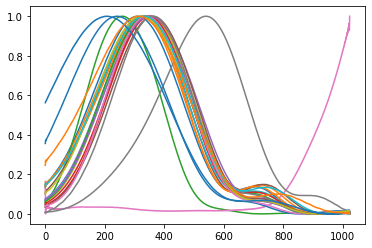

In [6]:
x = features['fal_z'].to_numpy().reshape(-1, N_SAMPLES)
for i in range(x.shape[0]):
    plt.plot(x[i, :])

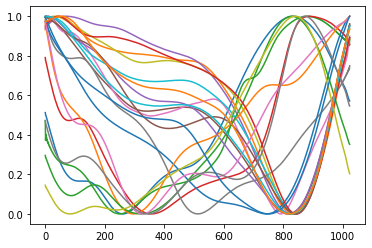

In [8]:
y = target['my'].to_numpy().reshape(-1, N_SAMPLES)
for i in range(y.shape[0]):
    plt.plot(y[i, :])

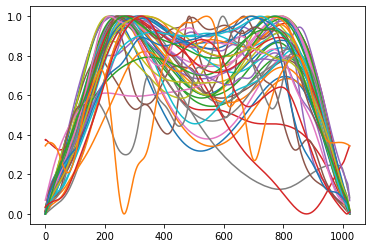

In [55]:
y = target['mx'].to_numpy().reshape(-1, N_SAMPLES)
for i in range(y.shape[0]):
    plt.plot(y[i, :])

In [18]:
path = '../../Dataset/Processed/data1_f15_t3_n1_p1.joblib'
data = {
    'X': features,
    'y': target
}
dump(data, path)

['../../Dataset/Processed/data1_f15_t3_n1_p1.joblib']

# Generating Train Test Sets

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import load, dump
from sklearn.model_selection import train_test_split

N_SAMPLES = 1024
N_CHANNELS = 15

# path = '../../Dataset/Processed/data2_f72_t3_n1_high_vel.joblib'
# data = load(path)
# features = data['X']
# target = data['y']

path1 = '../../Dataset/Processed/data1_f15_t3_n1_p1.joblib'
path2 = '../../Dataset/Processed/data1_f15_t3_n1_p2.joblib'

data1 = load(path1)
data2 = load(path2)

features1 = data1['X']
features2 = data2['X']

target1 = data1['y']
target2 = data2['y']

print(features1.shape)
print(features2.shape)

print(target1.shape)
print(target2.shape)

(45056, 18)
(954368, 18)
(45056, 6)
(954368, 3)


In [20]:
features = pd.concat([features1, features2])
target = pd.concat([target1, target2])

# print(features.shape)
# print(target.shape)

features

,fal_x,tam_x,fcc_x,fm1_x,fm2_x,fm5_x,fal_y,tam_y,fcc_y,fm1_y,fm2_y,fm5_y,fal_z,tam_z,fcc_z,fm1_z,fm2_z,fm5_z
0,0.101462,0.098248,0.109392,0.277911,0.223080,0.277076,0.955861,0.960769,0.953836,0.973061,0.972452,0.958030,0.433226,0.430723,0.494709,0.002328,0.002286,0.058812
1,0.088741,0.085280,0.096634,0.272035,0.216704,0.270931,1.000000,1.000000,1.000000,1.000000,1.000000,0.993467,0.456793,0.454022,0.520813,0.000000,0.000000,0.064479
2,0.126694,0.123197,0.134088,0.305769,0.253122,0.304582,0.979177,0.980308,0.979644,0.987253,0.986765,0.978513,0.450259,0.447408,0.513362,0.004490,0.003277,0.066261
3,0.086949,0.083212,0.094476,0.275027,0.220457,0.273909,0.988713,0.988094,0.990437,0.992970,0.992506,0.987128,0.457878,0.454885,0.521667,0.006047,0.004179,0.070120
4,0.129599,0.125940,0.136527,0.309496,0.258115,0.308652,0.978532,0.977986,0.981051,0.986623,0.985850,0.980443,0.456369,0.453298,0.519791,0.009728,0.006820,0.072857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954363,0.933796,0.940120,0.931910,0.890043,0.902638,0.899365,0.015060,0.015404,0.029790,0.015304,0.053953,0.174040,0.003092,0.003098,0.034523,0.010306,0.056364,0.038695
954364,0.934397,0.938431,0.933475,0.906120,0.914381,0.912336,0.026646,0.026549,0.042490,0.026238,0.065971,0.186801,0.005543,0.005656,0.037657,0.010219,0.055709,0.037749
954365,0.965601,0.968042,0.964899,0.948951,0.953982,0.952584,0.011798,0.012542,0.025726,0.011660,0.050928,0.172081,0.002536,0.002537,0.034066,0.010123,0.055828,0.038086
954366,0.951580,0.952222,0.951945,0.946227,0.947850,0.947697,0.032263,0.032128,0.048268,0.031290,0.072094,0.194066,0.006697,0.006923,0.039270,0.010414,0.055302,0.037050


In [21]:
features_new = features.drop(columns=['fcc_x', 'fcc_y', 'fcc_z'])
features_new = features_new[[
    'fal_x', 'tam_x', 'fm5_x', 'fm1_x', 'fm2_x',
    'fal_y', 'tam_y', 'fm5_y', 'fm1_y', 'fm2_y',
    'fal_z', 'tam_z', 'fm5_z', 'fm1_z', 'fm2_z'
]]
features_new

,fal_x,tam_x,fm5_x,fm1_x,fm2_x,fal_y,tam_y,fm5_y,fm1_y,fm2_y,fal_z,tam_z,fm5_z,fm1_z,fm2_z
0,0.101462,0.098248,0.277076,0.277911,0.223080,0.955861,0.960769,0.958030,0.973061,0.972452,0.433226,0.430723,0.058812,0.002328,0.002286
1,0.088741,0.085280,0.270931,0.272035,0.216704,1.000000,1.000000,0.993467,1.000000,1.000000,0.456793,0.454022,0.064479,0.000000,0.000000
2,0.126694,0.123197,0.304582,0.305769,0.253122,0.979177,0.980308,0.978513,0.987253,0.986765,0.450259,0.447408,0.066261,0.004490,0.003277
3,0.086949,0.083212,0.273909,0.275027,0.220457,0.988713,0.988094,0.987128,0.992970,0.992506,0.457878,0.454885,0.070120,0.006047,0.004179
4,0.129599,0.125940,0.308652,0.309496,0.258115,0.978532,0.977986,0.980443,0.986623,0.985850,0.456369,0.453298,0.072857,0.009728,0.006820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954363,0.933796,0.940120,0.899365,0.890043,0.902638,0.015060,0.015404,0.174040,0.015304,0.053953,0.003092,0.003098,0.038695,0.010306,0.056364
954364,0.934397,0.938431,0.912336,0.906120,0.914381,0.026646,0.026549,0.186801,0.026238,0.065971,0.005543,0.005656,0.037749,0.010219,0.055709
954365,0.965601,0.968042,0.952584,0.948951,0.953982,0.011798,0.012542,0.172081,0.011660,0.050928,0.002536,0.002537,0.038086,0.010123,0.055828
954366,0.951580,0.952222,0.947697,0.946227,0.947850,0.032263,0.032128,0.194066,0.031290,0.072094,0.006697,0.006923,0.037050,0.010414,0.055302


In [22]:
traget = target[['fy', 'fx', 'fz']]
traget

,fy,fx,fz
0,0.406638,0.176182,0.000523
1,0.403218,0.168727,0.002571
2,0.402282,0.165922,0.002750
3,0.400103,0.160800,0.008914
4,0.398638,0.157053,0.010577
...,...,...,...
954363,0.532504,0.139522,0.021939
954364,0.525758,0.146091,0.018014
954365,0.521084,0.151059,0.011613
954366,0.514225,0.157704,0.009454


In [23]:
X = features_new.to_numpy().reshape(-1, N_SAMPLES, N_CHANNELS)
y = target.to_numpy().reshape(-1, N_SAMPLES, 3)

print(X.shape)
print(y.shape)

(976, 1024, 15)
(1952, 1024, 3)


In [24]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

ValueError: Found input variables with inconsistent numbers of samples: [976, 1952]

In [ ]:
path = '../../Dataset/Processed/data1_f15_t3_n1_combined.joblib'
data = {
    'train_X': train_X,
    'test_X': test_X,
    'train_y': train_y,
    'test_y': test_y
}
dump(data, path)